<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Clientes

## 1) Introdução

Neste trabalho iremos analisar a base de dados disponibilizada online pela Olist.

Esta base refere-se ao desenvolvimento do comércio eletrônico no Brasil nos últimos anos, apresentando informações tanto das compras realizadas, quanto dos clientes que as fizeram, dos vendedores envolvidos e dos produtos comercializado neste tempo.

Nosso objetivo é explorar esta base de dados para tirar informações relevantes para serem utilizadas nos negócios, culminando com uma segmentação dos clientes, onde estes possam ser classificados de acordo com sua assiduidade às compras online.

## 2) Preparação dos dados

In [1]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

Cloning into 'olist-e-commerce'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 49 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


### 2.1) Gerando o dataframe

Para gerar um dataframe, iremos carregar os arquivos ***.csv*** de forma independente e depois iremos juntá-los uns aos outros através das chaves correspondentes.

In [3]:
# Carregando os datasets
customer = pd.read_csv('olist-e-commerce/olist_customers_dataset.csv')
orders = pd.read_csv('olist-e-commerce/olist_orders_dataset.csv')
orders_items = pd.read_csv('olist-e-commerce/olist_order_items_dataset.csv')

In [4]:
# Junção dos dataframes
df = pd.merge(right=orders,
             left=customer,
             on='customer_id')

df = pd.merge(right=orders_items,
             left=df,
             on='order_id')

In [5]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [6]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')

Número de linhas: 112650 
Número de colunas: 18


### 2.2) Verificando a consistência dos dados

Para utilizar nosso dataframe da forma ideal, precisamos inicialmente ter certeza que os dados estão consistentes, ou seja, no formato ideal, que não há valores faltantes na tabela, etc. Checaremos essas condições a seguir.

In [7]:
# Convertendo a coluna "order_purchase_timestamp" para o formato datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [8]:
# Confirmando os tipos dos dados de cada coluna
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [9]:
# Verificando os valores nulos
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

## 3) Modelo RFM

O modelo RFM é largamente utilizado para segmentação de clientes, levando em consideração as respectivas características:

- ***Recência (Recency)***: total de dias em que o cliente não realiza uma compra.
- ***Frequência (Frequency)***: número total de compras que o cliente já realizou.
- ***Monetaridade (Monetary)***: gasto total do cliente.

Iremos então descobrir cada uma dessas variáveis a partir do dataframe obtido acima.

### 3.1) Deletando colunas

Agora, criaremos dataframes específicos para cada uma das três variáveis de interesse para o modelo RFM. Para isso, excluiremos algumas colunas do dataframe original, deixando apenas as features que são mais relevantes para cada caso.

- ***Recência (R)***

In [10]:
# Criando o dataframe df_r para recência
df_r = df.drop(columns=['order_id', 'customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value', 'price'])

In [11]:
df_r.isnull().sum()

customer_unique_id          0
order_purchase_timestamp    0
dtype: int64

Como agora, para essas colunas não há valores nulos podemos partir diretamente para a análise.

In [12]:
# Criando uma data de referência
data_referencia = df_r['order_purchase_timestamp'].max() + timedelta(days=1)
print(f'Data de referência: {data_referencia}')

Data de referência: 2018-09-04 09:06:57


In [13]:
df_r = df_r.groupby(['customer_unique_id']).agg({'order_purchase_timestamp': lambda x: (data_referencia - x.max()).days})

In [14]:
df_r.reset_index(inplace=True)
df_r.rename(columns={'order_purchase_timestamp': 'recency'}, inplace=True)

In [15]:
df_r.head()

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293


- ***Frequência (F)***

In [16]:
# Criando o dataframe df_f para frequência
df_f = df.drop(columns=['order_purchase_timestamp', 'customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value', 'price'])

In [17]:
df_f = df_f.groupby('customer_unique_id').count()

In [18]:
df_f.rename(columns={'order_id': 'frequency'}, inplace=True)
df_f.reset_index(inplace=True)
df_f.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


- ***Monetaridade (M)***

In [19]:
# Criando o dataframe df_m para monetaridade
df_m = df.drop(columns=['order_id', 'order_purchase_timestamp', 'customer_id', 
                        'product_id', 'customer_zip_code_prefix', 
                        'customer_city', 'customer_state', 'order_status', 
                        'order_approved_at', 'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value'])

In [20]:
df_m = df_m.groupby('customer_unique_id').sum()

In [21]:
df_m.rename(columns={'price': 'monetary'}, inplace=True)
df_m.reset_index(inplace=True)
df_m.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


### 3.1) Agrupando clientes em cada dataframe

Nesta etapa iremos organizar os clientes com características semelhantes em grupos e classificá-los através de um label específico referente a tais grupos. Faremos para cada um dos dataframes acima (df_r, df_f, df_m) utilizando o algorítmo K-Means.

Iremos inicialmente definir variáveis correspondentes as colunas "recency", "frequency" e "monetary" dos respectivos dataframes e a seguir iremos definir o número de grupos apropriado. 

In [22]:
# Variável de df_r
X_R = df_r.iloc[:, [1]].values

# Variável de df_f
X_F = df_f.iloc[:, [1]].values

# Variável de df_m
X_M = df_m.iloc[:, [1]].values

In [23]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters(df):
  wcss = []
  X = df.iloc[:, [1]].values
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
  return wcss

In [24]:
wcss_r = define_clusters(df_r)
wcss_f = define_clusters(df_f)
wcss_m = define_clusters(df_m)

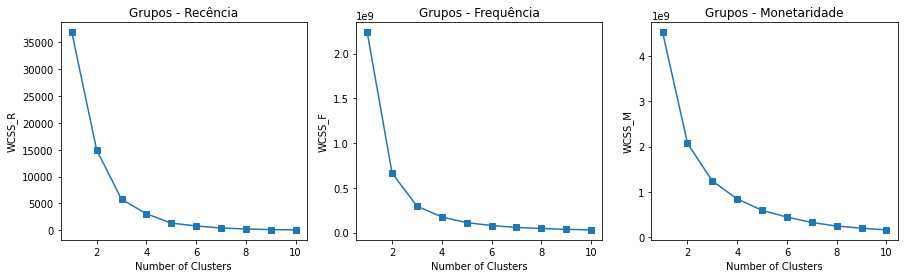

In [25]:
# Plotando os gráficos para cada dataframe
plt.figure(figsize=(15,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_f, marker='s')
plt.title('Grupos - Recência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_R')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_r, marker='s')
plt.title('Grupos - Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_F')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_m, marker='s')
plt.title('Grupos - Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_M')

plt.show()

Baseado nos plots acima, podemos considerar 4 grupos para cada variável. Assim, poderemos finalmente criar os grupos e os respectivos labels para cada caso. 

In [26]:
# Considerando portanto 4 clusters
def cluster_clients(df):
  X = df.iloc[:, [1]].values
  kmeans = KMeans(n_clusters=4, random_state=0)
  previsoes = kmeans.fit_predict(X)
  return previsoes

In [27]:
# Criando os labels para cada dataframe
label_r = cluster_clients(df_r)
label_f = cluster_clients(df_f)
label_m = cluster_clients(df_m)

In [28]:
df_r['R'] = label_r
df_f['F'] = label_f
df_m['M'] = label_m

In [29]:
df_r.head()

,customer_unique_id,recency,R
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3
2,0000f46a3911fa3c0805444483337064,542,2
3,0000f6ccb0745a6a4b88665a16c9f078,326,1
4,0004aac84e0df4da2b147fca70cf8255,293,1


In [30]:
df_f.head()

,customer_unique_id,frequency,F
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0
2,0000f46a3911fa3c0805444483337064,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0
4,0004aac84e0df4da2b147fca70cf8255,1,0


In [31]:
df_m.head()

,customer_unique_id,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,0
2,0000f46a3911fa3c0805444483337064,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,180.00,0


### 3.2) Rearranjando os índices dos labels

Um importante ajuste que necessita-se fazer agora é redefinir os labels R, F, M para que eles possam associar a cada grupo um grau de importância, atribuindo-se assim um "peso" para cada cluster. Neste ponto, podemos utilizar a seguinte referência:

- Recência: quanto maior, pior. Ordem de importância: 3, 2, 1, 0.
- Frequência: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3.
- Monetaridade: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3.

Assim, os labels precisam ser alterados da forma:

- R: 0 -> 2; 1 -> 1; 2 -> 0; 3 -> 3.
- F: 0 -> 0; 1 -> 2; 2 -> 1; 3 -> 3.
- M: 0 -> 0; 1 -> 2; 2 -> 3, 3 -> 1.

Podemos realizar este ajusta mediante uma função.

In [32]:
def adjust_index(df, column, label):
    if column == 'recency' and label == 'R':
        x = df.groupby(label).mean().sort_values(by=column, ascending=False).reset_index()       
    else:
        x = df.groupby(label).mean().sort_values(by=column, ascending=True).reset_index()
    index = tuple(zip(x.index, x[label].values))
    for c in index:
            df.loc[df[label] == c[1], f'adjusted_{label}'] = c[0] 
    return df

In [33]:
df_r = adjust_index(df_r, 'recency', 'R')
df_f = adjust_index(df_f, 'frequency', 'F')
df_m = adjust_index(df_m, 'monetary', 'M')

In [34]:
df_r.head()

,customer_unique_id,recency,R,adjusted_R
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,3.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,3.0
2,0000f46a3911fa3c0805444483337064,542,2,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,1.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,1.0


In [35]:
df_f.head()

,customer_unique_id,frequency,F,adjusted_F
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,0.0
2,0000f46a3911fa3c0805444483337064,1,0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,0,0.0


In [36]:
df_m.head()

,customer_unique_id,monetary,M,adjusted_M
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,0,0.0
2,0000f46a3911fa3c0805444483337064,69.00,0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,0,0.0
4,0004aac84e0df4da2b147fca70cf8255,180.00,0,0.0


### 3.3) Criando o dataframe final

Finalmente, podemos agora criar o dataframe final com os dados obtidos nos passos anteriores.

In [37]:
dados = {'customer_unique_id': df_r['customer_unique_id'],
         'recency': df_r['recency'],
         'R': df_r['adjusted_R'],
         'frequency': df_f['frequency'],
         'F': df_f['adjusted_F'],
         'monetary': df_m['monetary'],
         'M': df_m['adjusted_M']}

In [38]:
df_final = pd.DataFrame(dados)

In [39]:
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3.0,1,0.0,129.90,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3.0,1,0.0,18.90,0.0
2,0000f46a3911fa3c0805444483337064,542,0.0,1,0.0,69.00,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1.0,1,0.0,25.99,0.0
4,0004aac84e0df4da2b147fca70cf8255,293,1.0,1,0.0,180.00,0.0


## 4) Agrupando os clientes

Agora podemos fazer um agrupamento dos clientes considerando as variáveis recência, frequência e monetaridade duas a duas, obtendo assim três gráficos relacionando os clientes a cada uma das variáveis.

### 4.1) Escalonando as variáveis

O algorítmo usado para fazer agrupamentos, o K-Means, utiliza o cálculo de distância euclidiana entre os dados para plotar os pontos no gráfico. Um importante passo então, é deixar estas variáveis na mesma escala para que o resultado final fique o mais preciso e com a melhor acurácia possível.

In [40]:
# Criando o scaler
scaler = StandardScaler()

Começaremos separando as variáveis a serem utilizadas a seguir.

In [41]:
# Criando as variáveis

# Variáveis recência e frequência
X_RF = df_final.iloc[:, [1,3]].values

# Variáveis recência e monetaridade
X_RM = df_final.iloc[:, [1,5]].values

# Variáveis frequência e monetaridade
X_FM = df_final.iloc[:, [3,5]].values

- Escalonamento das variáveis

In [42]:
X_RF = scaler.fit_transform(X_RF)
X_RM = scaler.fit_transform(X_RM)
X_FM = scaler.fit_transform(X_FM)

In [43]:
X_RF

array([[-0.83312079, -0.2905643 ],
       [-0.81353336, -0.2905643 ],
       [ 1.94829305, -0.2905643 ],
       ...,
       [ 2.1506964 , -0.2905643 ],
       [-0.78088766, -0.2905643 ],
       [ 1.60224861, -0.2905643 ]])

In [44]:
X_RM

array([[-0.83312079, -0.05761497],
       [-0.81353336, -0.56759586],
       [ 1.94829305, -0.33741529],
       ...,
       [ 2.1506964 , -0.24139187],
       [-0.78088766, -0.12607186],
       [ 1.60224861, -0.39259431]])

In [45]:
X_FM

array([[-0.2905643 , -0.05761497],
       [-0.2905643 , -0.56759586],
       [-0.2905643 , -0.33741529],
       ...,
       [-0.2905643 , -0.24139187],
       [-0.2905643 , -0.12607186],
       [-0.2905643 , -0.39259431]])

### 4.2) Verificando o número ideal de clusters

Iremos novamente usar o Elbow Method para definir o número mais apropriado de grupos.

In [46]:
wcss_rf = []
wcss_rm = []
wcss_fm = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X_RF)
  wcss_rf.append(kmeans.inertia_)

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X_RM)
  wcss_rm.append(kmeans.inertia_)

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X_FM)
  wcss_fm.append(kmeans.inertia_)

In [47]:
wcss_rf

[190840.0,
 123688.78293929374,
 70316.90548889985,
 50718.9593878254,
 36275.61878752389,
 29345.2228670073,
 23299.94702144569,
 18805.445420201137,
 15255.072658594127,
 12834.957300519785]

In [48]:
wcss_rm

[190840.0,
 123726.5034536445,
 74198.40683970101,
 58793.24245321976,
 43834.4591202136,
 37572.030957731164,
 33031.94293697683,
 28469.43952448155,
 25177.848941173226,
 22693.742861865903]

In [49]:
wcss_fm

[190840.00000000003,
 127500.65626781646,
 85382.25433582606,
 61287.67922859735,
 46210.21573303964,
 38940.439767221214,
 31575.843087001977,
 26567.641212898125,
 22078.637500687335,
 19329.96699154336]

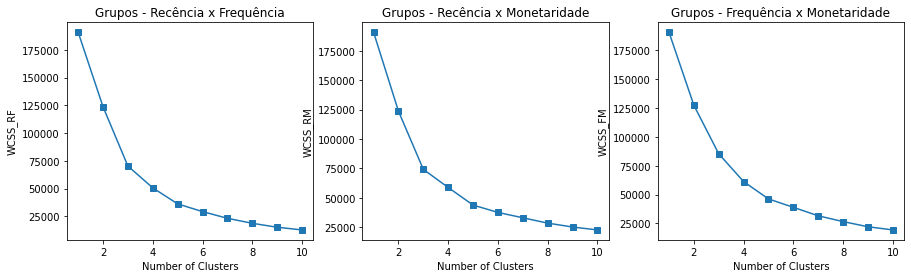

In [50]:
# Plotando os gráficos para cada wcss
plt.figure(figsize=(15,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_rf, marker='s')
plt.title('Grupos - Recência x Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_RF')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_rm, marker='s')
plt.title('Grupos - Recência x Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_RM')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_fm, marker='s')
plt.title('Grupos - Frequência x Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_FM')

plt.show()

Assim, podemos definir seis clusters para cada uma das relações. 